In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from geopy.distance import geodesic
import OLCdistance as olc

In [102]:
def parse_trackpoint(line):
    # Extract components from the line
    time_utc = line[1:7]  # HHMMSS
    latitude_raw = line[7:15]  # DDMMmmmN
    longitude_raw = line[15:24]  # DDDMMmmmE
    gps_altitude = int(line[25:30])  # GGGG
    pressure_altitude = int(line[30:35])  # LLLL

    # Convert UTC time
    hours = int(time_utc[:2])
    minutes = int(time_utc[2:4])
    seconds = int(time_utc[4:6])

    # Convert latitude to decimal degrees
    latitude_deg = int(latitude_raw[:2])
    latitude_min = float(latitude_raw[2:7]) / 1000
    latitude = latitude_deg + latitude_min / 60
    if latitude_raw[7] == 'S':
        latitude *= -1

    # Convert longitude to decimal degrees
    longitude_deg = int(longitude_raw[:3])
    longitude_min = float(longitude_raw[3:8]) / 1000
    longitude = longitude_deg + longitude_min / 60
    if longitude_raw[8] == 'W':
        longitude *= -1

    return {
        "time": f"{hours:02}:{minutes:02}:{seconds:02}",
        "coordinate": (latitude, longitude),
        "gps_altitude_m": gps_altitude,
        "pressure_altitude_m": pressure_altitude,
    }

In [103]:
file_name = "data/2024-08-03 09_11_21.igc"

with open(file_name, 'r') as file:
    lines = file.readlines()

flight_data = [line for line in lines if line.startswith('B')]
df = pd.DataFrame([parse_trackpoint(line) for line in flight_data])
del lines, flight_data
df.head()


,time,coordinate,gps_altitude_m,pressure_altitude_m
0,09:11:21,"(40.03145, 32.32855)",1142,1147
1,09:11:22,"(40.03145, 32.32855)",1142,1147
2,09:11:23,"(40.03145, 32.32855)",1142,1147
3,09:11:24,"(40.03145, 32.32855)",1142,1147
4,09:11:25,"(40.03143333333333, 32.32855)",1142,1147


In [104]:
for i in range(1, len(df)-1):
    if i % 10 > 0:
        df = df.drop([i])

flight_loginterval = int(df["time"].iloc[1][-2:]) - int(df["time"].iloc[0][-2:])

def calculate_distance(row):
    if row["previus_coordinate"] is None:
        return 0
    return geodesic(row["coordinate"], row["previus_coordinate"]).meters


prev_total_distance = 0
def caluculate_total_distance(row):
    global prev_total_distance
    prev_total_distance += row["distance_m"]
    return prev_total_distance

df["previus_coordinate"] = df["coordinate"].shift(1)
df["distance_m"] = df.apply(calculate_distance, axis=1)
df["total_distance_m"] = df.apply(lambda row: caluculate_total_distance(row), axis=1)
df["climb_m"] = df["gps_altitude_m"].diff()
df["climb_rate_m/s"] = df["climb_m"] / flight_loginterval
df["speed_km/s"] = (df["distance_m"]/1000) / (flight_loginterval/3600)
df["distance_from_start_m"] = df.apply(lambda row: geodesic(df["coordinate"].iloc[0], row["coordinate"]).meters, axis=1)
df.head()

,time,coordinate,gps_altitude_m,pressure_altitude_m,previus_coordinate,distance_m,total_distance_m,climb_m,climb_rate_m/s,speed_km/s,distance_from_start_m
0,09:11:21,"(40.03145, 32.32855)",1142,1147,None,0.000000,0.000000,NaN,NaN,0.000000,0.000000
10,09:11:31,"(40.03145, 32.32855)",1142,1149,"(40.03145, 32.32855)",0.000000,0.000000,0.0,0.0,0.000000,0.000000
20,09:11:41,"(40.03156666666667, 32.328266666666664)",1137,1140,"(40.03145, 32.32855)",27.434746,27.434746,-5.0,-0.5,9.876508,27.434746
30,09:11:51,"(40.0319, 32.32776666666667)",1147,1149,"(40.03156666666667, 32.328266666666664)",56.490789,83.925534,10.0,1.0,20.336684,83.468388
40,09:12:01,"(40.0327, 32.328383333333335)",1139,1141,"(40.0319, 32.32776666666667)",103.251459,187.176994,-8.0,-0.8,37.170525,139.521183


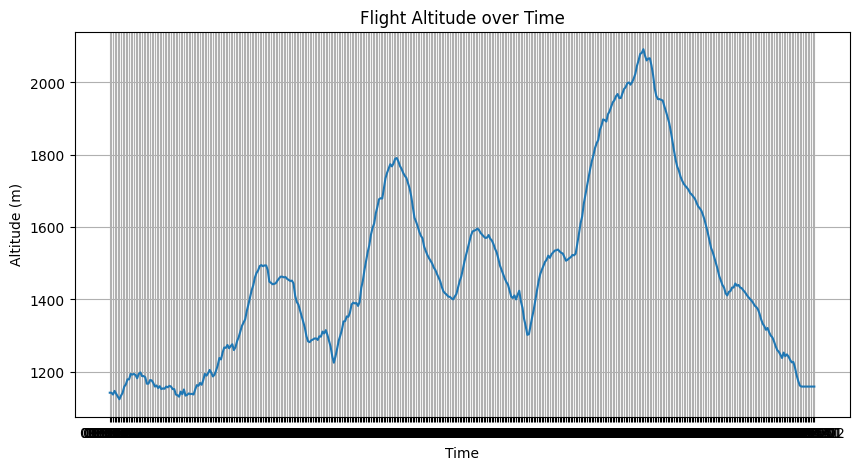

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['gps_altitude_m'])
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.title('Flight Altitude over Time')
plt.grid(True)
plt.show()

In [106]:
time_difference = str(pd.to_datetime(
    df['time'].iloc[-1]) - pd.to_datetime(df['time'].iloc[0]))
sonuc = (
    f"Toplam mesafe: {df['total_distance_m'].iloc[-1]/1000:.1f} km.\n"
    f"Maksimum yükseklik: {df['gps_altitude_m'].max()} m.\n"
    f"Maksimum tırmanma hızı: {df['climb_rate_m/s'].max()} m/s.\n"
    f"Maksimum iniş hızı: {df['climb_rate_m/s'].min()} m/s.\n"
    f"Maksimum Uzaklık: {df['distance_from_start_m'].max()/1000:.1f} km.\n"
    f"Ortalama hız: {df['speed_km/s'].mean():.1f} km/s.\n"
    f"Maksimum hız: {df['speed_km/s'].max():.1f} km/s.\n"
    f"Toplam süre: {time_difference.split()[2]}\n"
    f"Maksimum İrtifa: {df['pressure_altitude_m'].max()} m.\n"
    f"Minimum İrtifa: {df['pressure_altitude_m'].min()} m.\n"
    f"Kalkış İrtifası: {df['pressure_altitude_m'].iloc[0]} m.\n"
    f"Uçuşu Kayıt Aralığı (log interval): {flight_loginterval} s.\n"
)

df.to_csv("flight_data.csv", index=False)
print(sonuc)

Toplam mesafe: 35.8 km.
Maksimum yükseklik: 2092 m.
Maksimum tırmanma hızı: 3.9 m/s.
Maksimum iniş hızı: -3.7 m/s.
Maksimum Uzaklık: 1.9 km.
Ortalama hız: 29.4 km/s.
Maksimum hız: 58.8 km/s.
Toplam süre: 01:12:41
Maksimum İrtifa: 2150 m.
Minimum İrtifa: 1126 m.
Kalkış İrtifası: 1147 m.
Uçuşu Kayıt Aralığı (log interval): 10 s.



In [107]:
coordinates = df["coordinate"]

new_df = pd.DataFrame(0, index=range(len(coordinates)), columns=range(len(coordinates)))

for x in range(len(coordinates)):
    for y in range(len(coordinates)):
        new_df[x][y] = geodesic(coordinates[x], coordinates[y]).kilometers

new_df.describe()

# gps_points = df["coordinate"].tolist()
# distance, triangle = olc.fai_olc_distance(gps_points)
# print(f"Maximum FAI OLC Triangle Distance: {distance:.2f} km")
# print(f"Triangle Points: {triangle}")


/var/folders/ss/5qhyykzn7ws047pz5bmmgw1r0000gn/T/ipykernel_20063/3644643624.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_df[x][y] = geodesic(coordinates[x], coordinates[y]).kilometers


KeyError: 1

In [93]:
coordinates = df["coordinate"].to_list()
map = fm.Map(location=coordinates[0], zoom_start=13)
for coord in coordinates:
    fm.CircleMarker(location=coord, radius=1, color='blue',
                    fill=True, fill_color='blue', popup="Point").add_to(map)
for point in triangle:
    fm.Marker(location=point, popup="Triangle Point").add_to(map)
    
map.save("map.html")

NameError: name 'triangle' is not defined